# Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder 
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
pd.set_option("display.max_rows",100)
pd.set_option("display.max_columns",100)
pd.set_option("display.width",None)

2024-03-12 09:22:03.938908: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-12 09:22:03.939043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-12 09:22:04.124724: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv
/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv


# Reading the Files into Dataframe

In [2]:
train = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv", header=None, names=["id","entity","sentiment","tweet"])
test = pd.read_csv("/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv", header=None, names=["id","entity","sentiment","tweet"])

In [3]:
train.head()

,id,entity,sentiment,tweet
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [4]:
test.head()

,id,entity,sentiment,tweet
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


# Exploratory Data Analysis

In [5]:
train.describe()

,id
count,74682.000000
mean,6432.586165
std,3740.427870
min,1.000000
25%,3195.000000
50%,6422.000000
75%,9601.000000
max,13200.000000


In [6]:
test.describe()

,id
count,1000.000000
mean,6432.088000
std,3728.310569
min,6.000000
25%,3247.750000
50%,6550.000000
75%,9661.750000
max,13197.000000


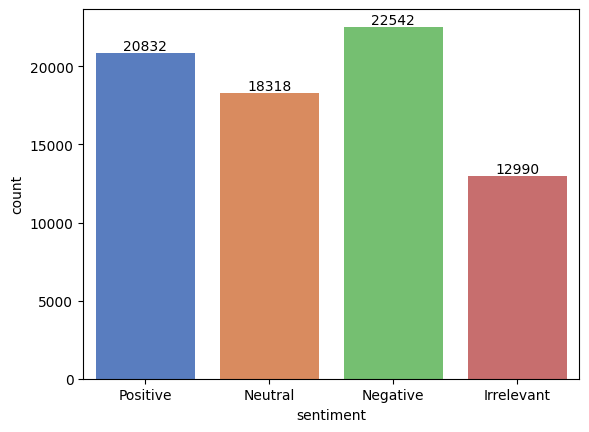

In [7]:
ax = sns.countplot(x='sentiment', data=train, palette='muted')
ax.bar_label(ax.containers[0], label_type='edge')
plt.show()

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   tweet      73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


# Data Cleaning and Data Preparation

Converting the object datatpye to strings and category. Changing the datatypes was necesarry for the regex operation.

In [9]:
train["entity"] = train["entity"].apply(str)
train["sentiment"] = train["sentiment"].astype("category")
train["tweet"] = train["tweet"].apply(str)

test["entity"] = test["entity"].apply(str)
test["sentiment"] = test["sentiment"].astype("category")
test["tweet"] = test["tweet"].apply(str)

In [10]:
def cleaning_tweets(tweet):
    #Removing all the @ mentions from the tweets
    tweet = re.sub(r"@[A-Za-z0-9]+","", tweet)
    
    #Removing the links from the tweets
    tweet = re.sub(r"https?://[A-Za-z0-9./]+","", tweet)
    
    #Removing unnecesarry characters like emojis from the tweets
    tweet = re.sub(r"[^ A-Za-z0-9.!?']","", tweet)
    
    #Removing any extra whitespaces
    tweet = re.sub(r" +"," ", tweet)
    
    return tweet

In [11]:
clean_tweets = [cleaning_tweets(tweet) for tweet in train['tweet']]
train['clean_tweets'] = clean_tweets

clean_tweets = [cleaning_tweets(tweet) for tweet in test['tweet']]
test['clean_tweets'] = clean_tweets

Removing the extra columns and only keeping the sentiment and tweets in the dataframe

In [12]:
cols = ['tweet','id','entity']
train.drop(cols, axis = 1, inplace = True)
test.drop(cols, axis = 1, inplace = True)

Handling the cetgorical column "sentiment" by using Label Encoding.

In [13]:
label_encoder = LabelEncoder() 
label_encoder.fit(train["sentiment"])

train["sentiment"]= label_encoder.transform(train["sentiment"])
test["sentiment"]= label_encoder.transform(test["sentiment"])

In [14]:
train.head()

,sentiment,clean_tweets
0,3,im getting on borderlands and i will murder yo...
1,3,I am coming to the borders and I will kill you...
2,3,im getting on borderlands and i will kill you all
3,3,im coming on borderlands and i will murder you...
4,3,im getting on borderlands 2 and i will murder ...


In [15]:
test.head()

,sentiment,clean_tweets
0,0,I mentioned on Facebook that I was struggling ...
1,2,BBC News Amazon boss Jeff Bezos rejects claims...
2,1,Why do I pay for WORD when it functions so po...
3,1,CSGO matchmaking is so full of closet hacking ...
4,2,Now the President is slapping Americans in the...


# Tokenization

Performing tokenization on train data using the SubwordTextEncoder to construct a subword vocabulary and then convert the text into numerical.

In [16]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    train["clean_tweets"], target_vocab_size=2**16
)

data_inputs = [tokenizer.encode(sentence) for sentence in train["clean_tweets"]]

Padding sequences with 0 to ensure uniform length across all input sequences in training data.

In [17]:
max_len = max(len(sentence) for sentence in data_inputs)

data_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    data_inputs, value=0, padding="post",maxlen=max_len
)

Performing the same tokenization and padding for test data.

In [18]:
test_inputs = [tokenizer.encode(sentence) for sentence in test["clean_tweets"]]

# Pad sequences in the test data
test_inputs = tf.keras.preprocessing.sequence.pad_sequences(
    test_inputs, value=0, padding="post", maxlen=max_len
)

# Model Development

Defining Deep Convolutional Neural Network (DCNN) model using TensorFlow's Keras API. 

In [19]:
class DCNN(tf.keras.Model):
    
    #Initializer method
    def __init__(self,
                 vocab_size,       #vocab_size: The size of the vocabulary.
                 emb_dim=128,      #emb_dim: The dimensionality of the embedding space.
                 nb_filters=50,    #nb_filters: The number of filters in the convolutional layers.
                 FFN_units=512,    #FFN_units: The number of units in the feedforward neural network layer.
                 nb_classes=4,     #nb_classes: The number of output classes.
                 dropout_rate=0.3, #The dropout rate for regularization.
                 training=False,   #training: A boolean indicating whether the model is in training mode or not.
                 name="dcnn"):     #name: The name of the model.
        super(DCNN, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocab_size, emb_dim) #Embedding layer: To learn the embeddings for input tokens.
        
        #Convolutional layers (bigram, trigram, quadgram): To capture different n-gram features/filters in the input.
        self.bigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size = 2,
                                    padding="same",
                                    activation="relu")
        
        #GlobalMaxPool1D layers: To pool the maximum value across the temporal dimension after convolution.
        self.pool_1 = layers.GlobalMaxPool1D()
        
        self.trigram = layers.Conv1D(filters=nb_filters,
                                    kernel_size = 3,
                                    padding="same",
                                    activation="relu")
        self.pool_2 = layers.GlobalMaxPool1D()
        
        self.quadgram = layers.Conv1D(filters=nb_filters,
                                    kernel_size = 4,
                                    padding="same",
                                    activation="relu")
        self.pool_3 = layers.GlobalMaxPool1D()
        
        #Dense layers: Fully connected layers for further processing.
        self.dense_1 = layers.Dense(units = FFN_units, activation="relu")
        
        #Dropout layer: For regularization by randomly dropping units during training.
        self.dropout = layers.Dropout(rate=dropout_rate)
        
        #Last Dense Layer: For output
        self.last_dense = layers.Dense(units = nb_classes, activation="softmax")
        
    #This method defines the forward pass of the model.
    def call(self, inputs, training):

        #The embeddings are first extracted from the input tokens using the Embedding layer.
        x = self.embedding(inputs)
        
        #The embedded sequences are then passed through convolutional layers (bigram, trigram, quadgram) 
        #followed by max-pooling layers (pool_1, pool_2, pool_3).
        x_1 = self.bigram(x)
        x_1 = self.pool_1(x_1)
        x_2 = self.trigram(x)
        x_2 = self.pool_2(x_2)
        x_3 = self.quadgram(x)
        x_3 = self.pool_3(x_3)

        #The outputs from these layers are concatenated along the feature axis (axis=-1).
        merged = tf.concat([x_1,x_2,x_3], axis=-1)
        
        #The concatenated features are passed through a dense layer (dense_1) followed by a dropout layer (dropout) for regularization.

        merged = self.dense_1(merged)
        merged = self.dropout(merged,training = training)
        
        #Finally, the output is passed through a dense layer (last_dense) with softmax activation to produce the final classification probabilities.
        output = self.last_dense(merged)
        
        return output

# Model Training

In [20]:
dcnn = DCNN(vocab_size = tokenizer.vocab_size)

In [21]:
dcnn.compile(loss="sparse_categorical_crossentropy", optimizer="Adam",metrics=["sparse_categorical_accuracy"])

In [22]:
dcnn.fit(data_inputs, train['sentiment'], batch_size=128, epochs=10)

Epoch 1/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 66s 110ms/step - loss: 1.0332 - sparse_categorical_accuracy: 0.5481
Epoch 2/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - loss: 0.1492 - sparse_categorical_accuracy: 0.9473
Epoch 3/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 82s 110ms/step - loss: 0.0773 - sparse_categorical_accuracy: 0.9682
Epoch 4/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 81s 108ms/step - loss: 0.0602 - sparse_categorical_accuracy: 0.9719
Epoch 5/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 84s 111ms/step - loss: 0.0553 - sparse_categorical_accuracy: 0.9736
Epoch 6/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 81s 109ms/step - loss: 0.0552 - sparse_categorical_accuracy: 0.9733
Epoch 7/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 83s 112ms/step - loss: 0.0546 - sparse_categorical_accuracy: 0.9739
Epoch 8/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 65s 111ms/step - loss: 0.0593 - sparse_categorical_accuracy: 0.9721
Epoch 9/10
584/584 ━━━━━━━━━━━━━━━━━━━━ 81s 110ms/step - loss: 0.0770 - sparse_categorical_accuracy: 0.9662
Epoch 10/10
584/584 ━━━━━━━━

# Model Evaluation

In [23]:
# Evaluate the model on the test data
loss, accuracy = dcnn.evaluate(test_inputs, test['sentiment'], batch_size=128)

# Print the evaluation metrics
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3153 - sparse_categorical_accuracy: 0.9412
Test Loss: 0.33958059549331665
Test Accuracy: 0.9419999718666077
